# Project 5 - Bayesian Statistics

In [16]:
# Imports
## For some arithmetic and Matrix Operations
import numpy as np

## Dataframe Manipulation
import pandas as pd

## For Visualization
import matplotlib.pyplot as plt

## For Visualization too
import seaborn as sns

## For Statistical Analysis
from scipy import stats



    For this project we will use the Hypothesis from Project 2:
    

**Our Test question:** Does the value of alcohol consumption differ between people who are considered to be suffering from depression and people who are not.

# Part 1
    Sampling the data

In [17]:
# Load the data
df = pd.read_csv('df_for_proj (1).csv')

# Picking a random sample of 200 rows.
np.random.seed(314)
observed_df = df.sample(200) # This data will be considered as the Observed data.

# Picking a random sample of a 1000 rows that are different than the 200 we just sampled.

# Getting the indices of the 200 rows we just sampled.
np.random.seed(314)
sampled_indices = observed_df.index
reduced_df = df.drop(sampled_indices) # get rid of the 200 samples we've worked with until now for this df.
#sample a 1000 rows from the reduced data
past_df = reduced_df.sample(1000) # sample 1000 from the reduced data. This data is the past data


Showing the distributions of our Explaining variables:

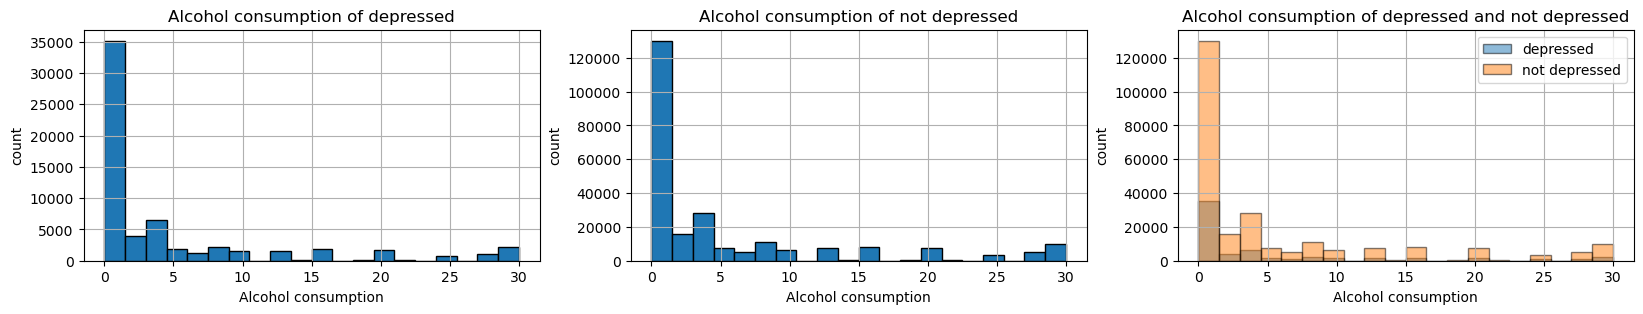

In [18]:

df_depressed = df[df['Depression']==1]
df_not_Depressed = df[df['Depression']==0]

fig,(ax1, ax2 ,ax3)= plt.subplots(1,3,figsize=(20,3))
df_depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax1)
ax1.set_title("Alcohol consumption of depressed")
ax1.set_xlabel("Alcohol consumption")
ax1.set_ylabel("count")


df_not_Depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax2)
ax2.set_title("Alcohol consumption of not depressed")
ax2.set_xlabel("Alcohol consumption")
ax2.set_ylabel("count")


df_depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax3, alpha=0.5, label='depressed')
df_not_Depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax3, alpha=0.5, label='not depressed')
ax3.set_title("Alcohol consumption of depressed and not depressed")
ax3.set_xlabel("Alcohol consumption")
ax3.set_ylabel("count")
plt.legend()
plt.show()

As we can see, and as we showed by using Permutation tests in the previous Project, Our two explaining variables 'Alcohol_Consumption|Depressed' and 'Alcohol_Consumption|Not_Depressed' come from the same distribution.

# Part 2
    Dichotomization

## Part 2.A
    Defining the Random Variable Z and estimating the log odds. 

In [19]:
# Create a function to calculate P_j 
    
def calc_pj(data1, data0, feature, tau):
    """
    Calculate the probabilitues P_j = P(Z=1|X_j) = P(X_j > tau), j = 1, 2
    data1: pandas dataframe - data for the first group
    data0: pandas dataframe - data for the second group
    feature: string - the name of the feature
    tau: float - the threshold value
    return: float, float - the probabilities P_1_1, P_0_1
    """
    num1_1 = len(data1[data1[feature]>tau].values)
    num1_0 = len(data1[data1[feature]<=tau].values)
    p_1_1 = num1_1/(num1_1+num1_0)
    
    num0_1 = len(data0[data0[feature]>tau].values)
    num0_0 = len(data0[data0[feature]<=tau].values)
    p_0_1 = num0_1/(num0_1+num0_0)

    return p_1_1, p_0_1


In [20]:
# Create a function to calculate the log odds ratio
def calc_psi(p_1_1, p_0_1):
    """
    Calculate the log odds ratio.
    p_1_1: float - The proportion of the target variable in the first population.
    p_0_1: float - The proportion of the target variable in the second population.
    return: float - The Population Stability Index (PSI) value.
    """
    return np.log(p_1_1/(1-p_1_1)) - np.log(p_0_1/(1-p_0_1))

In [21]:
# Defining a new binary Variable Z using Dichotomization.

# Defining tau to be the Median and creating dictionaries to hold the final results.
tau = observed_df['Alcohol_Consumption'].median()
psi_final = {} # This will hold the final results of the log odds ratio by the different methods.
CI_final = {} # This will hold the final results of the CI by the different methods.
CI_lens_final = {} # This will hold the final results of the CI lengths by the different methods.

depressed_df_obs = observed_df[observed_df['Depression']==1]
not_Depressed_df_obs = observed_df[observed_df['Depression']==0]
# Defining the probability P_j = P(Z=1|X_j) = P(X_j > tau), j=1,2.
p_depressed, p_not_depressed= calc_pj(depressed_df_obs, not_Depressed_df_obs, 'Alcohol_Consumption', tau)
psi = calc_psi(p_depressed, p_not_depressed) # log odds ratio.
# Print the log odds ratio. I.E print the estimation.
print("The log odds ratio between depressed and not depressed individuals is: ", psi)
# calculate CI using Bootstrap method.
n = 200
B = 400
bootstrap_samples = np.zeros(B)
for b in range(B):
    new_sample = observed_df.sample(n, replace=True)
    depressed_df_obs_boot = new_sample[new_sample['Depression']==1]
    not_Depressed_df_obs_boot = new_sample[new_sample['Depression']==0]

    p_depressed_boot, p_not_depressed_boot = calc_pj(depressed_df_obs_boot, not_Depressed_df_obs_boot, 'Alcohol_Consumption', tau)
    psi_boot = calc_psi(p_depressed_boot, p_not_depressed_boot)
    bootstrap_samples[b] = psi_boot
psi_bootstrap_mean = np.mean(bootstrap_samples)
# Append the final results.
psi_final['Bootstrap'] = psi_bootstrap_mean
# calculate CI using Bootstrap
normal_quantile = stats.norm.ppf(0.975)
se_boot = np.std(bootstrap_samples)
CI_boot =[psi_bootstrap_mean - normal_quantile*se_boot, psi_bootstrap_mean + normal_quantile*se_boot]
# Append the final results.
CI_lens_final['Bootstrap'] = (CI_boot[1]-CI_boot[0])
CI_final['Bootstrap'] = CI_boot
# Print the CI
print("The 95% CI for the log odds ratio between depressed and not depressed individuals is: ", CI_boot)



The log odds ratio between depressed and not depressed individuals is:  -0.04314733115625356
The 95% CI for the log odds ratio between depressed and not depressed individuals is:  [-0.7044509490271308, 0.6059056905924264]


## Part 2.B
    Using a Standard Uniform Prior to estimate Psi and calculate Credible interval.


The formula for the posterior calculations is added in the end of the pdf.

In [22]:
# Standard Uniform Prior function - pi.
# S is sum of bernuli variables.
num_depressed = len(depressed_df_obs) # m
num_not_depressed = len(not_Depressed_df_obs) # n
S_depressed_1 = len( depressed_df_obs[ depressed_df_obs['Alcohol_Consumption']>tau].values)
S_not_depressed_1 = len( not_Depressed_df_obs[ not_Depressed_df_obs['Alcohol_Consumption']>tau].values)
p_1_posterior = (S_depressed_1 + 1)/(num_depressed +2)
p_2_posterior = (S_not_depressed_1 + 1)/(num_not_depressed +2)
print("The posterior probability of Z=1 given that the individual is depressed is: ", p_1_posterior)
print("The posterior probability of Z=1 given that the individual is not depressed is: ", p_2_posterior)
psi = np.log(p_1_posterior/(1-p_1_posterior)) - np.log(p_2_posterior/(1-p_2_posterior))
print("The log odds ratio between depressed and not depressed individuals is: ", psi)



The posterior probability of Z=1 given that the individual is depressed is:  0.46808510638297873
The posterior probability of Z=1 given that the individual is not depressed is:  0.47770700636942676
The log odds ratio between depressed and not depressed individuals is:  -0.038602237781942245


In [23]:
# calculating credible interval according to the formula we saw in class.
B = 400
psi_simulation_samples = np.zeros(B)
for b in range(B):
    p1_beta = stats.beta.rvs(S_depressed_1+1, num_depressed-S_depressed_1+1, size=1)
    p2_beta = stats.beta.rvs(S_not_depressed_1+1, num_not_depressed-S_not_depressed_1+1, size=1)
    psi_simulation = np.log(p1_beta/(1-p1_beta)) - np.log(p2_beta/(1-p2_beta))
    psi_simulation_samples[b] = psi_simulation
psi_simulation_mean = np.mean(psi_simulation_samples)
# Append the final results.
psi_final['Standard Uniform Prior'] = psi_simulation_mean
print("The mean of the log odds ratio between depressed and not depressed individuals is: ", psi_simulation_mean)
CI_simulation =  [np.quantile(psi_simulation_samples, 0.025), np.quantile(psi_simulation_samples, 0.975)]
# Append the final results.
CI_lens_final['Standard Uniform Prior'] = (CI_simulation[1]-CI_simulation[0])
CI_final['Standard Uniform Prior'] = CI_simulation
# Print the CI
print("The 95% CI for the log odds ratio between depressed and not depressed individuals is: ", CI_simulation)



The mean of the log odds ratio between depressed and not depressed individuals is:  -0.058843211152423844
The 95% CI for the log odds ratio between depressed and not depressed individuals is:  [-0.663208728774235, 0.5385970508479143]


## Part 2.C
    Using Jeffreys Prior to estimate Psi and calculate Credible interval.


The formula for the posterior calculations is added in the end of the pdf.

In [24]:
# Assuming the non-informative prior pi(theta)=sqrt(I(theta)).
psi_simulation_samples = np.zeros(B)
for b in range(B):
    p1_beta = stats.beta.rvs(S_depressed_1+0.5, num_depressed-S_depressed_1+0.5, size=1)
    p2_beta = stats.beta.rvs(S_not_depressed_1+0.5, num_not_depressed-S_not_depressed_1+0.5, size=1)
    psi_simulation = np.log(p1_beta/(1-p1_beta)) - np.log(p2_beta/(1-p2_beta))
    psi_simulation_samples[b] = psi_simulation
psi_simulation_samples_mean = np.mean(psi_simulation_samples)
# Append the final results.
psi_final['Jeffreys Prior'] = psi_simulation_samples_mean
print("The log odds ratio between depressed and not depressed individuals is: ", psi_simulation_samples_mean)
CI_simulation =  [np.quantile(psi_simulation_samples, 0.025), np.quantile(psi_simulation_samples, 0.975)]
# Append the final results.
CI_lens_final['Jeffreys Prior'] = (CI_simulation[1]-CI_simulation[0])
CI_final['Jeffreys Prior'] = CI_simulation
# Print the CI 
print("The 95% CI for the log odds ratio between depressed and not depressed individuals is: ", CI_simulation)

The log odds ratio between depressed and not depressed individuals is:  -0.07111697806561801
The 95% CI for the log odds ratio between depressed and not depressed individuals is:  [-0.7381367567698307, 0.599183751769977]


## Part 2.D
    Using the Past data to calculate the prior for p_depressed and p_not depressed. We will assume the prior comes from a Beta distribution. Calculating the Aposterior Distribution, estimating Psi and calculating Credible interval.


In [25]:
# Using the past data to calculate the priors for p_depressed and p_not_depressed. Assume that the prior is from Beta dist.
# Calculate the number of depressed and not depressed individuals


depressed_df_past = past_df[past_df['Depression']==1]
not_Depressed_df_past = past_df[past_df['Depression']==0]

num_z_depressed_1 = len(depressed_df_past[depressed_df_past['Alcohol_Consumption']>tau].values)
num_z_depressed_0 =  len(depressed_df_past[depressed_df_past['Alcohol_Consumption']<=tau].values)

num_z_not_depressed_1 = len(not_Depressed_df_past[not_Depressed_df_past['Alcohol_Consumption']>tau].values)
num_z_not_depressed_0 = len(not_Depressed_df_past[not_Depressed_df_past['Alcohol_Consumption']<=tau].values)

# our data is binary, so we can use the beta distribution as a prior, and we will get the following:
s_depressed = num_z_depressed_1
n_depressed = num_z_depressed_1 + num_z_depressed_0
s_not_depressed = num_z_not_depressed_1
n_not_depressed = num_z_not_depressed_1 + num_z_not_depressed_0
alpha_depressed = s_depressed + 1 # alpha = S+1
beta_depressed = n_depressed - s_depressed + 1 # beta = n-S+1
alpha_not_depressed = s_not_depressed + 1 # alpha = S+1
beta_not_depressed = n_not_depressed - s_not_depressed + 1 # beta = n-S+1

print("The prior for p_depressed is: Beta(", alpha_depressed, ",", beta_depressed, ")")
print("The prior for p_not_depressed is: Beta(", alpha_not_depressed, ",", beta_not_depressed, ")")


The prior for p_depressed is: Beta( 103 , 100 )
The prior for p_not_depressed is: Beta( 444 , 357 )


The formula for the posterior calculations is added in the end of the pdf.

In [26]:
# Using the Aposteriori Distributions we found for p1,p2 to estimate psi and the Credible Interval.

num_z_depressed_1 =  len(depressed_df_obs[depressed_df_obs['Alcohol_Consumption']>tau].values)
num_z_depressed_0 = len(depressed_df_obs[depressed_df_obs['Alcohol_Consumption']<=tau].values)


num_z_not_depressed_1 =  len(not_Depressed_df_obs[not_Depressed_df_obs['Alcohol_Consumption']>tau].values)
num_z_not_depressed_0 =  len(not_Depressed_df_obs[not_Depressed_df_obs['Alcohol_Consumption']<=tau].values)

# our data is binary, so we can use the beta distribution as a prior.
s_depressed = num_z_depressed_1
n_depressed = num_z_depressed_1 + num_z_depressed_0
s_not_depressed = num_z_not_depressed_1
n_not_depressed = num_z_not_depressed_1 + num_z_not_depressed_0

psi_simulation_samples = np.zeros(B)    
for b in range(B):
    p1_beta = stats.beta.rvs(s_depressed+90, n_depressed-s_depressed+113, size=1)
    p2_beta = stats.beta.rvs(s_not_depressed+375, n_not_depressed-s_not_depressed+426, size=1)
    psi_simulation = np.log(p1_beta/(1-p1_beta)) - np.log(p2_beta/(1-p2_beta))
    psi_simulation_samples[b] = psi_simulation
psi_simulation_samples_mean = np.mean(psi_simulation_samples)
# Append the final results.
psi_final['Aposteriori Distributions'] = psi_simulation_samples_mean
print("The log odds ratio between depressed and not depressed individuals is: ", psi_simulation_samples_mean)
CI_simulation =  [np.quantile(psi_simulation_samples, 0.025), np.quantile(psi_simulation_samples, 0.975)]
# Append the final results.
CI_lens_final['Aposteriori Distributions'] = (CI_simulation[1]-CI_simulation[0])
CI_final['Aposteriori Distributions'] = CI_simulation
# Print the CI
print("The 95% CI for the log odds ratio between depressed and not depressed individuals is: ", CI_simulation)


The log odds ratio between depressed and not depressed individuals is:  -0.07957641380385211
The 95% CI for the log odds ratio between depressed and not depressed individuals is:  [-0.34834212385965696, 0.1874450108760785]


## Part 2.E
    Comparing all the estimators of psi we found.

In [27]:
# Comparing the estimations of psi using the different priors.
# We will compare the values of psi and plot the lengths of the Credible Intervals from each prior.
psi_final_df = pd.DataFrame(psi_final.items(), columns=['Prior', 'Value'])
print("The final results of the log odds ratio between depressed and not depressed individuals are: ")
psi_final_df.head()




The final results of the log odds ratio between depressed and not depressed individuals are: 


,Prior,Value
0,Bootstrap,-0.049273
1,Standard Uniform Prior,-0.058843
2,Jeffreys Prior,-0.071117
3,Aposteriori Distributions,-0.079576


In [28]:
CI_lens_final_df = pd.DataFrame(CI_lens_final.items(), columns=['Prior', 'CI Length'])
print("The final results of the CI lengths for the log odds ratio between depressed and not depressed individuals are: ")
CI_lens_final_df.head()


The final results of the CI lengths for the log odds ratio between depressed and not depressed individuals are: 


,Prior,CI Length
0,Bootstrap,1.310357
1,Standard Uniform Prior,1.201806
2,Jeffreys Prior,1.337321
3,Aposteriori Distributions,0.535787


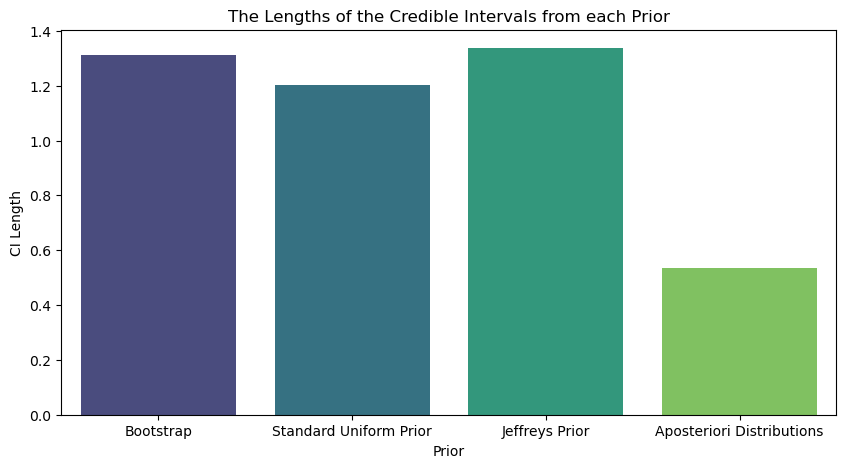

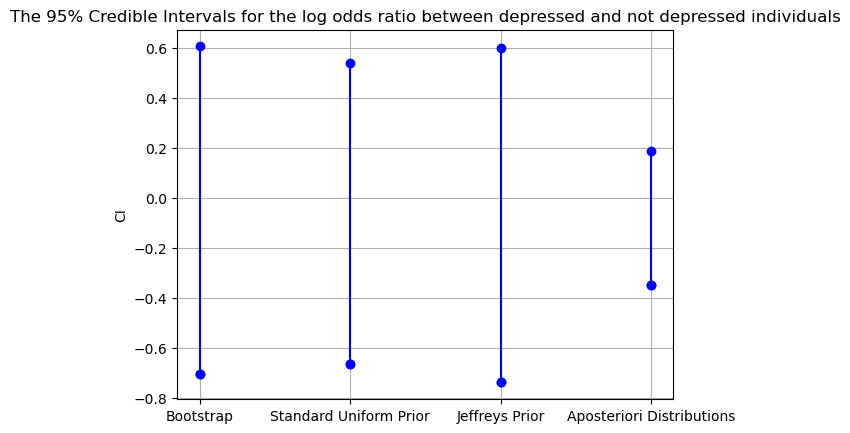

In [29]:
# Plot the lengths of the Credible Intervals from each prior using an intervals plot.
plt.figure(figsize=(10,5))
sns.barplot(x='Prior', y='CI Length', data=CI_lens_final_df, palette='viridis')
plt.title("The Lengths of the Credible Intervals from each Prior")
plt.show()

# Plot the CI as a start an end and a line between them.
for key, value in CI_final.items():
    plt.plot([key, key], [value[0], value[1]], marker='o', color='blue')
    plt.plot(key, value[0], marker='o', color='blue')

plt.title("The 95% Credible Intervals for the log odds ratio between depressed and not depressed individuals")
plt.ylabel("CI")
plt.grid()
plt.show()




    Corollaries: 

We can see that when we based our calculations on the past data (final method), we got the shortest and most accurate Credible Interval. We saw in class that when we have a lot of past data we will give more weight to the data and not to the prior - making the outcome more accurate, and when we don't have a lot of past data we will give more weight to the Prior, thus ending up with a less accurate result. We can also see that when we didn't rely on past data - i.e methods 1-3, the CI lengths were about the same.